In [1]:
import gc

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from shared.local_path import *
from shared.utils import *

### Read Image Data

In [2]:
filepath = []
label = []

i = 0
for classes in os.listdir(TRAIN_IMAGE_PATH):
    for file in os.listdir(os.path.join(TRAIN_IMAGE_PATH, classes)):
        path = os.path.join(TRAIN_IMAGE_PATH, classes, file)
        filepath.append(path)
        label.append(classes)

train_df = pd.DataFrame({
    'filepath': filepath,
    'label': label
})

del filepath, label

print(train_df.shape)
print(train_df['label'].unique())
train_df.head()

(33479, 2)
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


,filepath,label
0,E:\Skripsi\data\new_data\train\angry\angry_0_1...,angry
1,E:\Skripsi\data\new_data\train\angry\angry_0_1...,angry
2,E:\Skripsi\data\new_data\train\angry\angry_0_1...,angry
3,E:\Skripsi\data\new_data\train\angry\angry_0_1...,angry
4,E:\Skripsi\data\new_data\train\angry\angry_0_1...,angry


In [3]:
filepath = []
label = []

i = 0
for classes in os.listdir(TEST_IMAGE_PATH):
    for file in os.listdir(os.path.join(TEST_IMAGE_PATH, classes)):
        path = os.path.join(TEST_IMAGE_PATH, classes, file)
        filepath.append(path)
        label.append(classes)

img_test_df = pd.DataFrame({
    'filepath': filepath,
    'label': label
})

del filepath, label

print(img_test_df.shape)
print(img_test_df['label'].unique())
img_test_df.head()

(7831, 2)
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


,filepath,label
0,E:\Skripsi\data\new_data\test\angry\Anger.jpg,angry
1,E:\Skripsi\data\new_data\test\angry\Anger_1.jpg,angry
2,E:\Skripsi\data\new_data\test\angry\Anger_10.jpg,angry
3,E:\Skripsi\data\new_data\test\angry\Anger_11.jpg,angry
4,E:\Skripsi\data\new_data\test\angry\Anger_12.jpg,angry


In [4]:
le = LabelEncoder()
le.fit(train_df['label'])
train_df['label_encoded'] = le.transform(train_df['label'])
img_test_df['label_encoded'] = le.transform(img_test_df['label'])

## transform the filepath into image data

In [5]:
with tf.device('/GPU:0'):
    train_df['data'] = train_df['filepath'].apply(
        lambda x: preprocess_image(x, (100, 100), preprocess_function=tf.keras.applications.vgg19.preprocess_input, augment=True))
    img_test_df['data'] = img_test_df['filepath'].apply(
        lambda x: preprocess_image(x, (100, 100), preprocess_function=tf.keras.applications.vgg19.preprocess_input)
    )


## Split and Shuffle Dataset into train, val, and test

In [6]:
# Image Data
# train_df = train_df.sample(frac=1, random_state=19).reset_index(drop=True)
train_df, img_val_df = train_test_split(train_df, test_size=.2, random_state=100, shuffle=True)

## Downsampling with following least dataset amount

In [7]:
# train_df, audio = downsample_df(train_df, audio)
# img_val_df, aud_val_df = downsample_df(img_val_df, aud_val_df)
# img_test_df, aud_test_df = downsample_df(img_test_df, aud_test_df)

In [8]:
# print(len(train_df))
# print(len(img_val_df))
# print(len(img_test_df))
# 
# print("===============================")
# 
# print(len(audio))
# print(len(aud_val_df))
# print(len(aud_test_df))

## Convert to Numpy

In [9]:
# # Audio Data
# x_audio_train = np.stack(audio['data'].values)
# y_audio_train = np.array(audio['label_encoded'].values)
# 
# x_audio_val = np.stack(aud_val_df['data'].values)
# y_audio_val = np.array(aud_val_df['label_encoded'].values)
# 
# x_audio_test = np.stack(aud_test_df['data'].values)
# y_audio_test = np.array(aud_test_df['label_encoded'].values)

In [10]:
train_df.data.iloc[1].shape

(100, 100, 3)

In [11]:
x_img_train = np.stack(train_df['data'].values)
y_img_train = np.array(train_df['label_encoded'].values)

x_img_val = np.stack(img_val_df['data'].values)
y_img_val = np.array(img_val_df['label_encoded'].values)

x_img_test = np.stack(img_test_df['data'].values)
y_img_test = np.array(img_test_df['label_encoded'].values)

In [12]:
del train_df, img_val_df, img_test_df

# Modeling
## Creating Model

In [13]:
base = tf.keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(100, 100, 3),
    pooling=None
)

for layer in base.layers:
    layer.trainable = False


In [14]:
input_image = tf.keras.Input(shape=(100, 100, 3), name='input_image')

left = base(input_image)
left = tf.keras.layers.GlobalAveragePooling2D()(left)
# left = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.01))(left)
# left = tf.keras.layers.Dense(512, activation='relu')(left)
# left = tf.keras.layers.Dense(512, activation='relu')(left)
out1 = tf.keras.layers.Dense(7, activation='softmax', name='image_class')(left)

model = tf.keras.models.Model(input_image, out1)

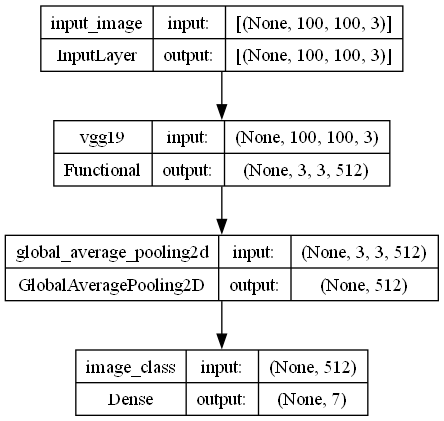

In [15]:
plot_model(model, show_shapes=True, show_layer_names=True)

## Compile the model

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics='accuracy',
)

In [17]:
tf.keras.backend.clear_session()
gc.collect()

162

In [18]:
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True,
    mode='min',
    # start_from_epoch=2,
    patience=5
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join('model', 'best_model.keras'),
    verbose=2,
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                    factor=0.1,
                                                    min_lr=1e-6,
                                                    patience=3,
                                                    mode='min'
                                                    )

## Train the model

In [19]:
gc.collect()
tf.keras.backend.clear_session()

In [ ]:
history = model.fit(
    x=x_img_train,
    y=y_img_train,
    validation_data=(
        x_img_val,
        y_img_val
    ),
    callbacks=[lr_scheduler],
    epochs=100,
    batch_size=BATCH_SIZE,
    steps_per_epoch=len(x_img_train) // BATCH_SIZE,
    validation_steps=len(x_img_val) // BATCH_SIZE,
)


Epoch 1/100
418/418 [==============================] - 38s 72ms/step - loss: 3.7271 - accuracy: 0.2786 - val_loss: 2.3221 - val_accuracy: 0.3392 - lr: 0.0010
Epoch 2/100
418/418 [==============================] - 30s 68ms/step - loss: 1.9864 - accuracy: 0.3605 - val_loss: 1.8466 - val_accuracy: 0.3770 - lr: 0.0010
Epoch 3/100
418/418 [==============================] - 29s 68ms/step - loss: 1.6883 - accuracy: 0.3984 - val_loss: 1.6828 - val_accuracy: 0.3908 - lr: 0.0010
Epoch 4/100
418/418 [==============================] - 29s 68ms/step - loss: 1.6060 - accuracy: 0.4137 - val_loss: 1.6293 - val_accuracy: 0.4002 - lr: 0.0010
Epoch 5/100
418/418 [==============================] - 29s 68ms/step - loss: 1.5817 - accuracy: 0.4157 - val_loss: 1.6126 - val_accuracy: 0.4001 - lr: 0.0010
Epoch 6/100
418/418 [==============================] - 29s 68ms/step - loss: 1.5699 - accuracy: 0.4186 - val_loss: 1.6114 - val_accuracy: 0.4085 - lr: 0.0010
Epoch 7/100
418/418 [==============================]

## Plot the training result

In [21]:
def plot_and_save(metric_name, history, ylabel, filename):
    plt.figure()
    plt.plot(history.history[metric_name], label=f'Train {ylabel}')
    if f'val_{metric_name}' in history.history:
        plt.plot(history.history[f'val_{metric_name}'], label=f'Val {ylabel}')
    plt.title(f'{ylabel} over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    plt.close()

In [22]:
plot_and_save('loss', history, 'Loss', 'image_loss_plot.png')
plot_and_save('accuracy', history, 'Image Classification Accuracy', 'image_class_accuracy_plot.png')

# Evaluation
## Using model.evaluate

In [23]:
gc.collect()
tf.keras.backend.clear_session()

In [24]:
model.evaluate(x_img_val, y_img_val, batch_size=BATCH_SIZE, verbose=2,
               steps=len(x_img_val) // BATCH_SIZE)

104/104 - 5s - loss: 2.2010 - accuracy: 0.4444 - 5s/epoch - 50ms/step


[2.2009730339050293, 0.4444110691547394]

In [25]:
model.evaluate(x_img_test, y_img_test, batch_size=BATCH_SIZE, verbose=2,
               steps=len(x_img_test) // BATCH_SIZE)

122/122 - 6s - loss: 2.5601 - accuracy: 0.4091 - 6s/epoch - 50ms/step


[2.560077428817749, 0.40906763076782227]

## Using confusion matrix

In [26]:
predictions = model.predict(x_img_test)
predictions = np.argmax(predictions, axis=1)

classes = [x for x in os.listdir(TRAIN_IMAGE_PATH)]
print(classes)

245/245 [==============================] - 8s 28ms/step
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


### Plot the confusion Matrix

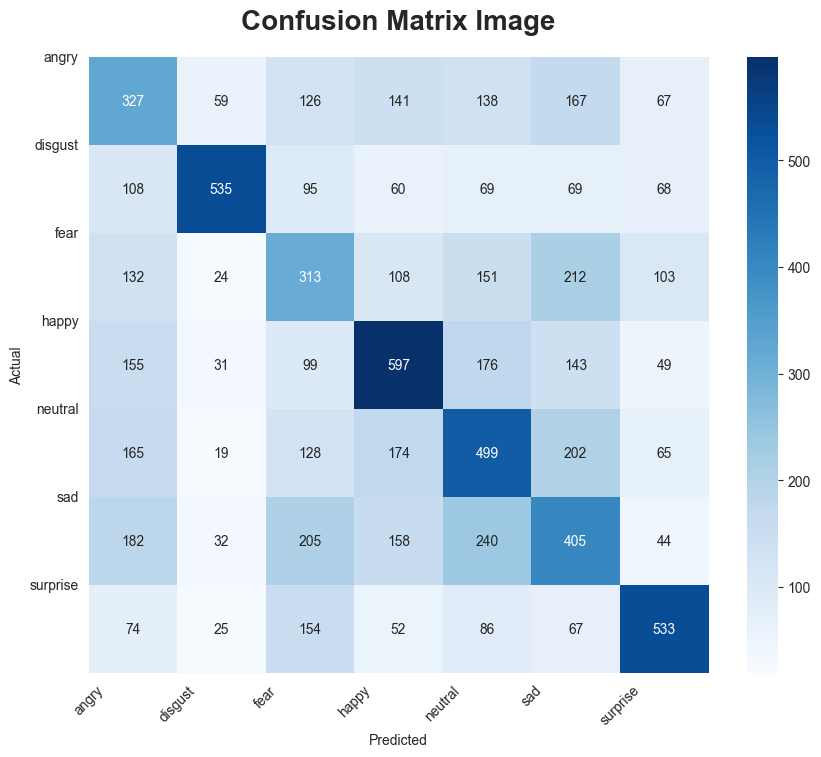

In [27]:
cm = confusion_matrix(y_img_test, predictions)
plt.figure(figsize=(10, 8))  # Set the figure size if needed
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix Image', pad=20, fontsize=20, fontweight="bold")
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.xticks(ticks=range(len(classes)), labels=classes, rotation=45)
plt.yticks(ticks=range(len(classes)), labels=classes, rotation=0)
plt.savefig('confusion_matrix_image.png', dpi=300, bbox_inches='tight')
plt.show()

In [28]:
# plt.figure(figsize=(10, 8))  # Set the figure size if needed
# sns.heatmap(audio_cm, annot=True, cmap='Blues', fmt='g')
# 
# plt.title('Confusion Matrix Audio', pad=20, fontsize=20, fontweight="bold")
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# 
# plt.xticks(ticks=range(len(aud_classes)), labels=aud_classes, rotation=45)
# plt.yticks(ticks=range(len(aud_classes)), labels=aud_classes, rotation=0)
# plt.savefig('confusion_matrix_audio.png', dpi=300, bbox_inches='tight')
# plt.show()

In [29]:
print(classification_report(y_img_test, predictions))

              precision    recall  f1-score   support

           0       0.29      0.32      0.30      1025
           1       0.74      0.53      0.62      1004
           2       0.28      0.30      0.29      1043
           3       0.46      0.48      0.47      1250
           4       0.37      0.40      0.38      1252
           5       0.32      0.32      0.32      1266
           6       0.57      0.54      0.56       991

    accuracy                           0.41      7831
   macro avg       0.43      0.41      0.42      7831
weighted avg       0.43      0.41      0.42      7831



In [30]:
# print(classification_report(y_audio_test, audio_class))

In [31]:
model.save('model_sc4t5_img.h5')